In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import re


In [56]:
info_folder = "~/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/trained_models/"
ground_truth = "/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv"

v1_output = info_folder+"output_v1_val.csv" # 0.8062 narrowing = 0.6135 erosion = 1.2509

v2_output = info_folder+"output_v2_sgd.csv" # 1.4157 narrowing = 1.0169 erosion = 1.7587

v3_output = info_folder+"adam_no_weights_val_output.csv" # 0.7772	0.5506	0.5025

v4_output = info_folder+"adam_no_weights_reg_val_output.csv" # 0.7479	0.4865	0.4889

v5_output = info_folder+"adam_no_weights_reg_combined_narrowing_shuffle_val_output.csv" # 0.7603	0.5133	0.4677



In [92]:
ground_truth_df = pd.read_csv(ground_truth)
v1_output_df = pd.read_csv(v1_output)
v2_output_df = pd.read_csv(v2_output)
v3_output_df = pd.read_csv(v3_output)
v4_output_df = pd.read_csv(v4_output)
v5_output_df = pd.read_csv(v5_output)
v6_output_df = pd.read_csv(info_folder + "adam_no_weights_reg_shuffle_hand_pretrain_val_output.csv")

zeros_df = pd.read_csv(v1_output)
zeros_df.loc[:,["Patient_ID" not in x for x in zeros_df.columns]] = 0
mean_of_train = pd.read_csv(v1_output)
for col in mean_of_train.columns[1:]:
    mean_of_train.loc[:,col] = ground_truth_df[col].mean()

a1 = pd.read_csv(info_folder + "adam_adapted_weights_val_output.csv")
a2 = pd.read_csv(info_folder + "adam_no_weights_val_combined_narrowing_output.csv")
a3 = pd.read_csv(info_folder + "adam_no_weights_reg_combined_narrowing_val_output.csv")

names = ["v1_output_df","v2_output_df","v3_output_df","v4_output_df","v5_output_df","v6_output_df","a1","a2","a3","zeros_df","mean_of_train"]
data = [v1_output_df,v2_output_df,v3_output_df,v4_output_df,v5_output_df,v6_output_df,a1,a2,a3,zeros_df,mean_of_train]
all_data = {x:y for x,y in zip(names,data)}

In [93]:
ground_truth_df

,Patient_ID,Overall_Tol,Overall_erosion,Overall_narrowing,LH_mcp_E__ip,LH_pip_E__2,LH_pip_E__3,LH_pip_E__4,LH_pip_E__5,LH_mcp_E__1,...,LF_mtp_J__2,LF_mtp_J__3,LF_mtp_J__4,LF_mtp_J__5,RF_mtp_J__ip,RF_mtp_J__1,RF_mtp_J__2,RF_mtp_J__3,RF_mtp_J__4,RF_mtp_J__5
0,UAB001,45,2,43,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
1,UAB002,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,UAB003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UAB005,6,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,UAB006,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,UAB716,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,UAB717,20,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,UAB719,25,1,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,UAB720,35,6,29,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
def overall_plot(truth,sample, what = "Tol"):
    a=sample[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]].merge(truth[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]],how="inner",on = "Patient_ID")
    fig, ax = plt.subplots()
    sns.scatterplot(data = a, x = f"Overall_{what}_x", y = f"Overall_{what}_y")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.ylabel("ground truth")
    plt.ylim((-5,250))
    plt.xlim((-5,250))
    fig.set_size_inches(5, 5)
    
def calculate_error(truth,sample, what = "Tol"):
    a=sample[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]].merge(truth[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]],how="inner",on = "Patient_ID")
    return mean_squared_error(a[f"Overall_{what}_y"], a[f"Overall_{what}_x"]), mean_absolute_error(a[f"Overall_{what}_y"], a[f"Overall_{what}_x"])

def get_truth_vs_samples(truth,sample,what=".*J.*"):
    truth = truth.set_index("Patient_ID")
    sample = sample.set_index("Patient_ID")
    what = re.compile(what)
    wanted_cols = list(filter(what.match, truth.columns))
    a=sample.loc[:,wanted_cols].merge(truth.loc[:,wanted_cols],how="inner",left_index=True, right_index=True)
    truth_idx = ["_y" in x for x in a.columns]
    sample_idx = ["_x" in x for x in a.columns]
    truth_classes = a.loc[:,truth_idx].values.flatten().tolist()
    sample_classes = a.loc[:,sample_idx].values.flatten().tolist()
    return truth_classes, sample_classes

def per_class_rmse(truth,sample,what=".*J.*"):
    def _mse(data):
        return mean_squared_error(data["sample"],data["truths"])
    
    truth_classes, sample_classes = get_truth_vs_samples(truth,sample,what)
    df = pd.DataFrame([truth_classes,sample_classes]).T
    df.columns = "truths sample".split()
    return df.groupby("truths").apply(_mse)

In [95]:
for i in all_data:
    print(calculate_error(ground_truth_df,all_data[i],"erosion"))
print()
for i in all_data:
    print(calculate_error(ground_truth_df,all_data[i],"narrowing"))

(530.3279179541635, 7.584115446340928)
(321.67905107427873, 12.472206888795819)
(461.9384231242915, 6.749445491916905)
(385.59937089124736, 6.369754553499186)
(330.6150234717186, 6.176968221066763)
(363.238016472848, 6.240125963504871)
(534.5253794375459, 7.665461150087791)
(479.2992600614941, 7.249554551867534)
(385.59937089124736, 6.369754553499186)
(825.75, 9.83695652173913)
(729.7404300567109, 12.599007561436672)

(141.10313016503892, 5.489777750587195)
(164.07300686106836, 9.425503558467438)
(144.1929868235793, 5.701149428504857)
(115.1478808542427, 4.933255852665751)
(102.35231141546555, 5.109607696087788)
(107.73487798515256, 4.960229234810432)
(123.73480721761288, 5.5080746234133775)
(129.67950585051008, 5.539304830983747)
(87.72642270654727, 4.676328843196287)
(1049.6630434782608, 14.402173913043478)
(844.5643977433837, 18.168241965973536)


/mnt/jw01-aruk-home01/projects/ra_challenge/tensorflow2.0_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


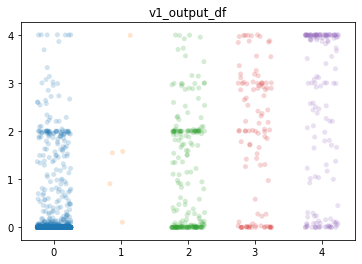

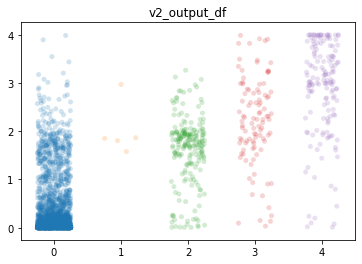

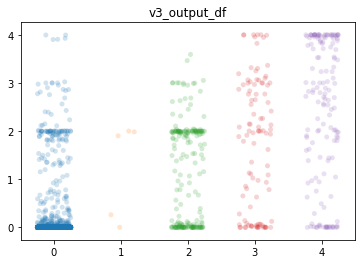

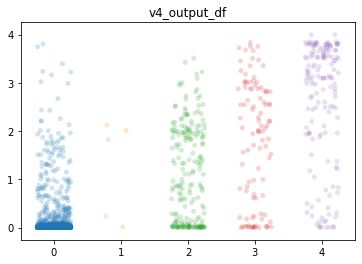

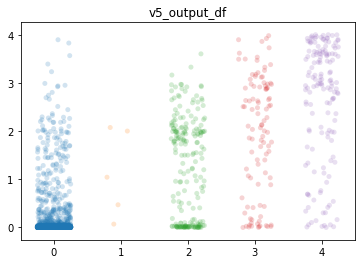

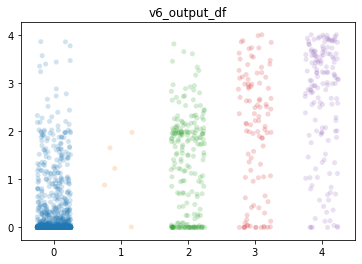

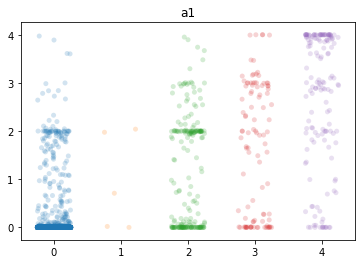

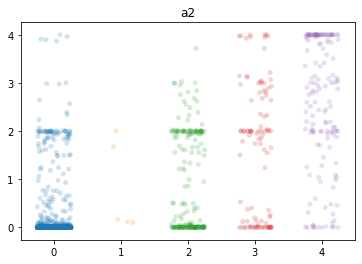

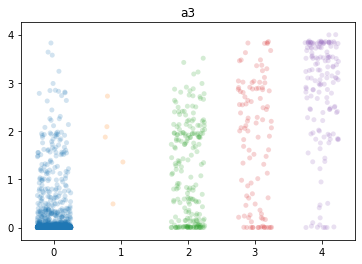

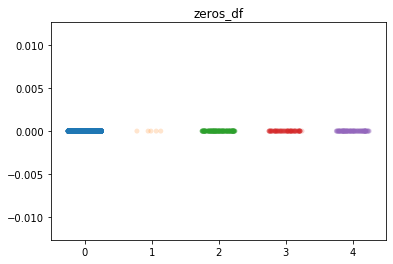

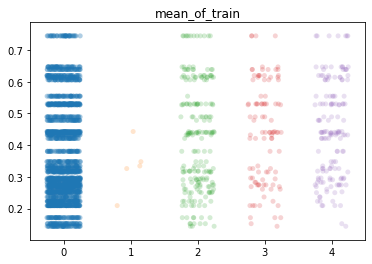

In [119]:
for i in all_data:
    fig, ax = plt.subplots()
    t, s = get_truth_vs_samples(ground_truth_df,all_data[i],".*J.*")
    sns.stripplot(x=t, y=s,alpha=0.2,jitter=0.25)
    plt.title(i)
    fig.show()

In [97]:
res = pd.DataFrame()
for i in all_data:
    a = pd.DataFrame(per_class_rmse(ground_truth_df,all_data[i],".*J.*")).reset_index(level=0, drop=True)
    res[i] = a[0]**(1/2)

In [98]:
res

,v1_output_df,v2_output_df,v3_output_df,v4_output_df,v5_output_df,v6_output_df,a1,a2,a3,zeros_df,mean_of_train
0,0.426013,0.611049,0.407552,0.292216,0.369349,0.379785,0.363375,0.338028,0.334070,0.0,0.401261
1,1.439365,1.125816,0.929405,0.951526,0.812939,0.695432,0.903004,0.864063,1.031824,1.0,0.672064
2,1.433008,0.787020,1.312530,1.316155,1.266373,1.192557,1.399574,1.479795,1.291336,2.0,1.589147
3,1.731238,1.199315,1.844854,1.726063,1.608695,1.613406,1.889126,1.918024,1.732581,3.0,2.566385
4,2.242725,1.488124,2.142547,1.866517,1.840890,1.804718,1.907615,1.937261,1.611146,4.0,3.556173


In [115]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept = False)

In [116]:
lm.fit(res[["v1_output_df","v2_output_df","v3_output_df","v4_output_df","v5_output_df","v6_output_df","mean_of_train"]].T,
       [0.6135,1.0169,0.5506,0.4865,0.5133,0.5572,0.815])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [117]:
lm.coef_

array([ 1.31460284,  0.13151401, -0.66438829,  0.38498892,  0.07080857])

In [118]:
lm.score(res[["v1_output_df","v2_output_df","v3_output_df","v4_output_df","v5_output_df","v6_output_df","mean_of_train"]].T,
         [0.6135,1.0169,0.5506,0.4865,0.5133,0.5572,0.815])

0.9404873941488822